In [1]:
import pandas as pd
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy.misc import imresize
import keras.backend as K
import numpy as np
from keras.regularizers import l2
from sklearn.utils import compute_class_weight
from IPython.display import display
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model, Sequential
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_label(path):
    label = pd.read_table(path, sep=',', header=None)
    label.columns=['video','jpg', 'interesting', 'level', 'key_frame']
    label = label.groupby(['jpg'], sort=False, as_index=False).max()
    return label

train_label = load_label('data/devset-image.txt')
test_label = load_label('data/testset-image.txt')

train_label.head(2)

,jpg,video,interesting,level,key_frame
0,107_102-113.jpg,video_0,0,0.099801,36
1,129_114-144.jpg,video_0,0,0.029117,46


In [41]:
train = np.load('data/train_array.npy')
y = np.array(train_label['interesting'])
test = np.load('data/test_array.npy')
y_test = np.array(test_label['interesting'])

In [4]:
# for i in range(3):
#     display(array_to_img(train[i]))

In [5]:
# check = pd.read_csv('weights_history.csv')
# del check['Unnamed: 0']
# print(check)
# check.plot()

In [6]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
print(weights)
# plt.hist(y);

[ 0.55267278  5.2462845 ]


In [55]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(216, 384, 3)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Activation('relu'))
model.add(Dropout(0.9))
model.add(Dense(2, activation='softmax', W_regularizer=l2(0.5)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 214, 382, 64)      1792      
_________________________________________________________________
dropout_9 (Dropout)          (None, 214, 382, 64)      0         
_________________________________________________________________
activation_13 (Activation)   (None, 214, 382, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 107, 191, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 105, 189, 64)      36928     
_________________________________________________________________
dropout_10 (Dropout)         (None, 105, 189, 64)      0         
_________________________________________________________________
activation_14 (Activation)   (None, 105, 189, 64)      0         
__________

/home/DL/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app


In [56]:
# model = Sequential()
# model.add(Conv2D(64, (5, 5), input_shape=(216, 384, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(2, activation = 'softmax', kernel_regularizer=l2(0.01)))

# model.summary()

In [57]:
# v3 = VGG19(weights='imagenet', include_top=False,
#                      input_shape=(216, 384, 3))

# x = Flatten(name='flatten')(v3.layers[-3].output)
# x = Dense(1, activation='sigmoid', name='predictions')(x)
# model = Model(inputs=v3.input, outputs=x)

# for layer in model.layers:
#     if layer.name in ['drop','flatten','predictions']:
#         continue
#     layer.trainable = False

# df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
# df.style.applymap(lambda trainable: f'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

In [58]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [59]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
             metrics=[precision, recall])

history = model.fit(train, 
                    to_categorical(y),
                    validation_split=.1, 
                    epochs=5, 
                    class_weight=weights)

Train on 4447 samples, validate on 495 samples
Epoch 1/5
4447/4447 [==============================] - 729s - loss: 2.4019 - precision: 0.8989 - recall: 0.8988 - val_loss: 2.0385 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 2/5
4447/4447 [==============================] - 729s - loss: 2.0705 - precision: 0.9031 - recall: 0.9031 - val_loss: 1.7713 - val_precision: 0.9172 - val_recall: 0.9172
Epoch 3/5
4447/4447 [==============================] - 728s - loss: 1.8680 - precision: 0.9033 - recall: 0.9033 - val_loss: 1.5986 - val_precision: 0.9172 - val_recall: 0.9172
Epoch 4/5
4447/4447 [==============================] - 726s - loss: 1.7589 - precision: 0.9033 - recall: 0.9033 - val_loss: 1.5263 - val_precision: 0.9172 - val_recall: 0.9172
Epoch 5/5
4447/4447 [==============================] - 727s - loss: 3.2356 - precision: 0.8842 - recall: 0.8842 - val_loss: 3.2972 - val_precision: 0.9172 - val_recall: 0.9172


In [60]:
preds = model.predict(test)

Counter({0: 2314}) 0.895851339672


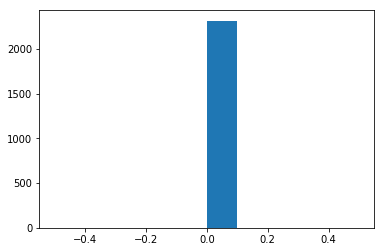

In [61]:
outcome = np.argmax(preds, axis=1)
plt.hist(np.argmax(preds, axis=1))
print(Counter(outcome), sum(outcome==y_test)/len(y_test))
plt.show()